#%%[markdown]

 # Neural ODE framework with mixture of experts
## Summary
 - We have a multiple dynamical systems that we want to learn
 - We first learn the neural on trajectories from both attractors (initialisation)
 - We then relearn on a single attrator
 - Does it unlearn the other attractor ?

In [ ]:
#%%

import jax

print("\n############# Neural ODE #############\n")
print("Available devices:", jax.devices())

from jax import config
##  Debug nans
# config.update("jax_debug_nans", True)

import jax.numpy as jnp
import jax.scipy as jsp
import jax.scipy.optimize

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx

import matplotlib.pyplot as plt

from graphpint.utils import *
from graphpint.integrators import *

import optax
from functools import partial
import time


############# Neural ODE #############

Available devices: [cuda(id=0)]


In [ ]:
#%%

# SEED = 27
SEED = 2024

## Integrator hps
integrator = rk4_integrator
# integrator = dopri_integrator

## Optimiser hps
init_lr = 1e-3
decay_rate = 0.9

## Training hps
print_every = 1000
nb_epochs = 50000
# batch_size = 128*10

skip = 100

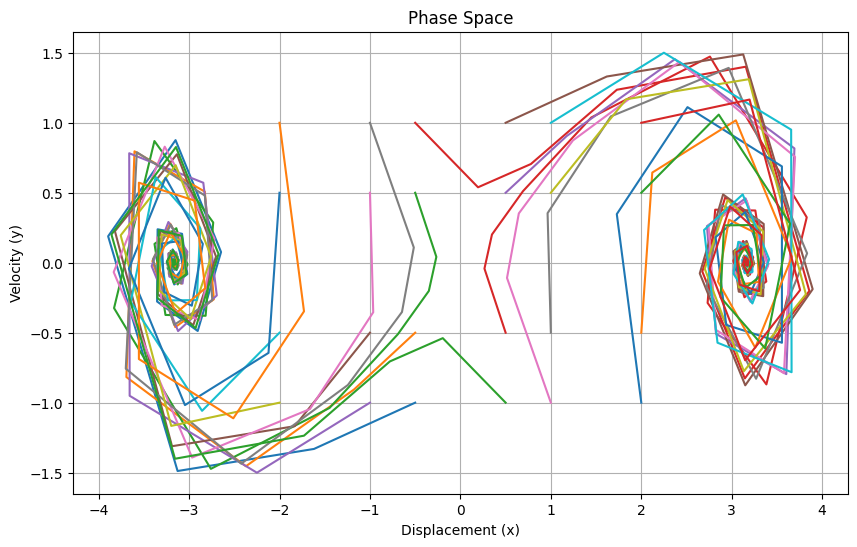

In [ ]:
#%%

# Define the Duffing system
def duffing(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = a*y - x*(b + c*x**2)
    return [dxdt, dydt]

# Parameters
a, b, c = -1/2., -1, 1/10.

t_span = (0, 40)
t_eval = np.arange(t_span[0], t_span[1], 0.01)[::skip]


plt.figure(figsize=(10, 6))

init_conds = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                    #    [-1.5, 1], 
                       [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                       [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                       [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                       [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])


train_data = []

for state0 in init_conds:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data.append(sol.y.T)

    ## Plot the phase space
    plt.plot(sol.y[0], sol.y[1])
    plt.xlabel('Displacement (x)')
    plt.ylabel('Velocity (y)')
    plt.title('Phase Space')
    plt.grid(True)

plt.show()

## Save the training data
data = np.stack(train_data)[None, ...]

In [ ]:
# %%

def topk_routing(x, k):
    # sort and print
    values, indices = jax.lax.top_k(x, k)
    ret = jnp.full_like(x, -jnp.inf)
    ret = ret.at[indices].set(values)
    # jax.debug.print("Printing top k values: {} {} {}", ret, x, indices)
    # print("Printing top k values: ", ret, values, indices)
    return ret


class Processor(eqx.Module):
    # layers: list
    layers1: list
    layers2: list
    # layers_rout: list
    params_router: jnp.ndarray

    def __init__(self, in_size=2, out_size=2, key=None):
        # keys = get_new_key(key, num=6)

        # # self.layers_rout = [eqx.nn.Linear(in_size, 16, key=keys[4]), jax.nn.relu,
        # self.layers_rout = [eqx.nn.Linear(in_size, 10, key=keys[4]),
        #                     eqx.nn.Linear(10, 2, key=keys[4])]

        # self.layers1 = [eqx.nn.Linear(in_size, 64, key=keys[0]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, 64, key=keys[2]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, out_size, key=keys[3]) ]

        # self.layers2 = [eqx.nn.Linear(in_size, 64, key=keys[0]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, 64, key=keys[2]), jax.nn.softplus,
        #                 eqx.nn.Linear(64, out_size, key=keys[3]) ]


        keys = get_new_key(key, num=5)

        # self.layers_rout = [eqx.nn.Linear(in_size, 8, key=keys[0]), jax.nn.tanh, eqx.nn.Linear(8, 2, key=keys[0])]
        self.params_router = jax.random.normal(keys[0], (in_size,))

        self.layers1 = [eqx.nn.Linear(in_size, 64, key=keys[0]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, out_size, key=keys[2]) ]

        self.layers2 = [eqx.nn.Linear(in_size, 64, key=keys[0]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, out_size, key=keys[2]) ]

    def __call__(self, x, t):

        ## Top 1 routing function
        # w_out = x
        # for layer in self.layers_rout:
        #     w_out = layer(w_out)
        # gate = jax.nn.softmax(topk_routing(w_out, 1))

        w_out = self.params_router@x.T
        gate = jax.lax.cond(w_out>0, lambda x: jnp.array([1., 0.]), lambda x: jnp.array([0., 1.]), x)

        # y = x
        # for layer in self.layers:
        #     y = layer(y)
        # return y

        y1 = x
        y2 = x
        for i in range(len(self.layers1)):
            y1 = self.layers1[i](y1)
            y2 = self.layers2[i](y2)

        return gate[0]*y1 + gate[1]*y2

In [ ]:
# %%

model_keys = get_new_key(SEED, num=2)
model = Processor(in_size=2, out_size=2, key=model_keys[0])


params, static = eqx.partition(model, eqx.is_array)
params_flat, params_shapes, tree_def = flatten_pytree(params)

In [ ]:
# %%

def params_norm(params):
    return jnp.array([jnp.sum(jnp.abs(x)) for x in jax.tree_util.tree_leaves(params)]).sum()

def l2_norm(X, X_hat):
    total_loss = jnp.mean((X - X_hat)**2, axis=-1)   ## Norm of d-dimensional vectors
    return jnp.sum(total_loss) / (X.shape[-2])



=== Beginning Training ... ===

Compiling function "train_step" ...


Compiling function "loss_fn" ...

    Epoch:     0      Loss: 195.30830383
    Epoch:     1      Loss: 63.06786728
    Epoch:     2      Loss: 19.77848625
    Epoch:     3      Loss: 3.44726324
    Epoch:  1000      Loss: 0.11771598
    Epoch:  2000      Loss: 0.08397229
    Epoch:  3000      Loss: 0.06250202
    Epoch:  4000      Loss: 0.04751383
    Epoch:  5000      Loss: 0.02678842
    Epoch:  6000      Loss: 0.00759003
    Epoch:  7000      Loss: 0.00122971
    Epoch:  8000      Loss: 0.00091160
    Epoch:  9000      Loss: 0.00038066
    Epoch: 10000      Loss: 0.00016411
    Epoch: 11000      Loss: 0.00031490
    Epoch: 12000      Loss: 0.00015177
    Epoch: 13000      Loss: 0.00005406
    Epoch: 14000      Loss: 0.00010642
    Epoch: 15000      Loss: 0.00009961
    Epoch: 16000      Loss: 0.00004937
    Epoch: 17000      Loss: 0.00004035
    Epoch: 18000      Loss: 0.00008015
    Epoch: 19000      Loss: 0.00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Total GD training time: 0 hours 24 mins 55 secs


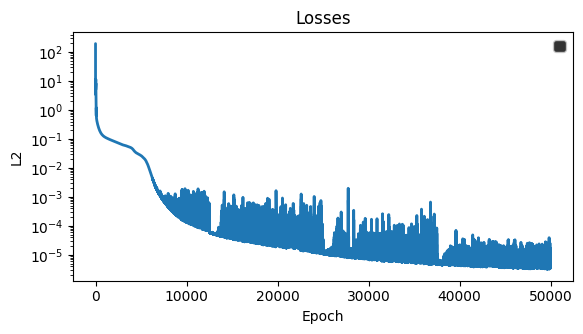

In [ ]:
# %%

### ==== Vanilla Gradient Descent optimisation ==== ####

def loss_fn(params, static, batch):
    print('\nCompiling function "loss_fn" ...\n')
    X, t = batch

    rhs = eqx.combine(params, static)

    # X_hat = integrator(rhs, X[0, 0, :], t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")
    X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None)
                     )(rhs, X[:, 0, :], t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return jnp.mean((X-X_hat)**2)
    # return l2_norm(X, X_hat)
    # return 1e0*params_norm(params_env)
    # return l2_norm(X, X_hat) + 1e-0*params_norm(params_env)


@partial(jax.jit, static_argnums=(1))
def train_step(params, static, batch, opt_state):
    print('\nCompiling function "train_step" ...\n')

    loss, grads = jax.value_and_grad(loss_fn)(params, static, batch)

    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss


total_steps = nb_epochs

# sched = optax.exponential_decay(init_lr, total_steps, decay_rate)
# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
sched_factor = 0.5
sched = optax.piecewise_constant_schedule(init_value=init_lr,
                                            boundaries_and_scales={int(total_steps*0.25):sched_factor, 
                                                                    int(total_steps*0.5):sched_factor,
                                                                    int(total_steps*0.75):sched_factor})
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
nb_data_points = data.shape[1]
batch_size = nb_data_points

start_time = time.time()


print(f"\n\n=== Beginning Training ... ===")

opt = optax.adam(sched)
opt_state = opt.init(params)

losses = []
for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum = 0.
    for i in range(0, nb_data_points, batch_size):
        batch = (data[0,i:i+batch_size,...], t_eval)
    
        params, opt_state, loss = train_step(params, static, batch, opt_state)

        loss_sum += loss
        nb_batches += 1

    loss_epoch = loss_sum/nb_batches
    losses.append(loss_epoch)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"    Epoch: {epoch:-5d}      Loss: {loss_epoch:.8f}", flush=True)


# ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title=f'Loss for environment {e}', ax=ax);
ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title='Losses', ax=ax);
plt.savefig(f"data/loss_simple.png", dpi=300, bbox_inches='tight')
# plt.show()
plt.legend()
fig.canvas.draw()
fig.canvas.flush_events()

wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

In [ ]:
# %%

# model = eqx.tree_deserialise_leaves("data/model_02.eqx", model)
# params, static = eqx.partition(model, eqx.is_array)

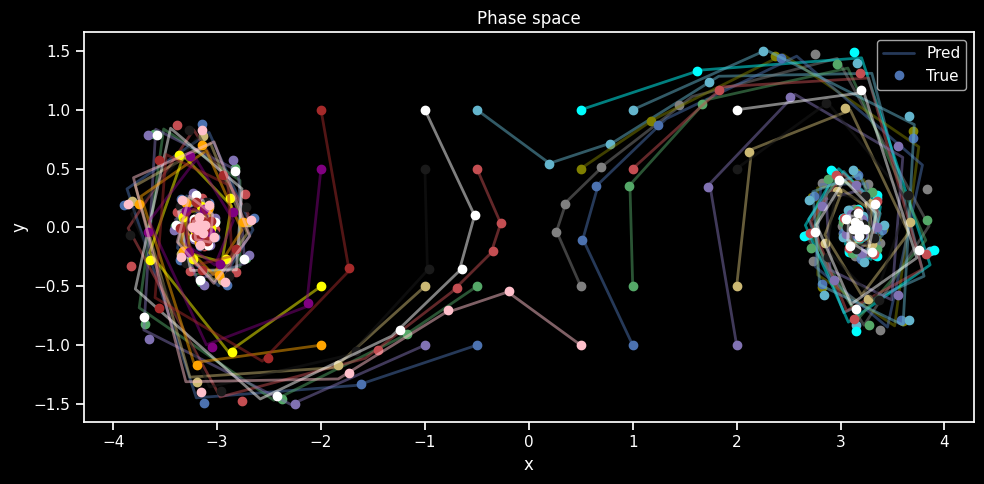

In [ ]:
# %%

def test_model(params, static, batch):
    X0, t = batch
    rhs = eqx.combine(params, static)

    X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None)
                     )(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")
    # X_hat = integrator(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return X_hat


i = np.random.randint(0, 1)

X = data[0, :, :, :]
t = np.linspace(t_span[0], t_span[1], 40)       ## TODO important

X_hat = test_model(params, static, (X[:, 0,:], t))

# print("L2 error:", jnp.mean((X-X_hat)**2))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))



colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors*10

for i in range(X.shape[0]):
#     if i==0:
#         ax = sbplot(t, X_hat[i, :, 0], x_label='Time', y_label='Displacement', label=f'Pred', title=f'Trajectory {i}', ax=ax)
#         ax = sbplot(t, X[i, :, 0], "--", lw=1, label=f'True', ax=ax)
#     else:
#         ax = sbplot(t, X_hat[i, :, 0], x_label='Time', y_label='Displacement', title=f'Trajectory {i}', ax=ax)
#         ax = sbplot(t, X[i, :, 0], "--", lw=1, ax=ax)

    if i==0:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', label=f'Pred', title=f'Phase space', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "o", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "o", lw=1, ax=ax, color=colors[i])

# plt.savefig(f"data/coda_test_env{e}_traj{i}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"data/test_simple.png", dpi=300, bbox_inches='tight')

In [ ]:
#%% 

model = eqx.combine(params, static)
eqx.tree_serialise_leaves("data/model_04.eqx", model)

# %% [markdown]

 # Preliminary results
 - Nothing yet
 # Conclusion



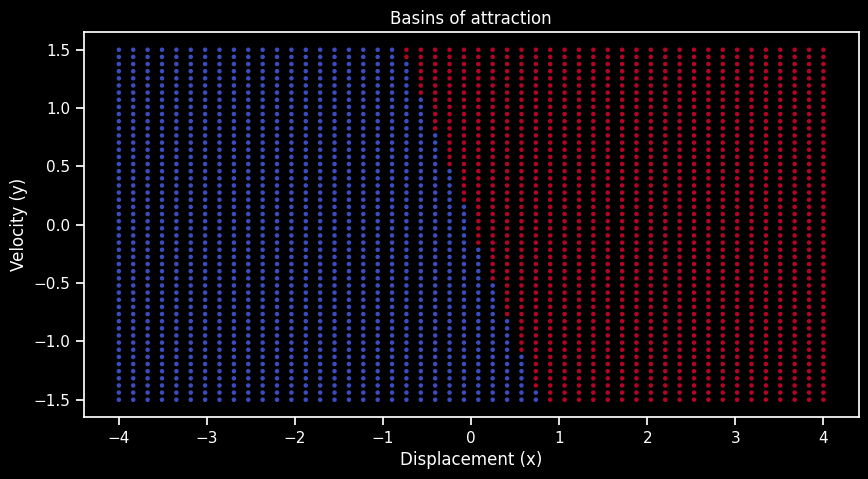

In [ ]:
# %%

## Check if the router has identified the correct attractor

# Samples points in the rectangle [-4,4]x[-1.5,1.5]
# import numpy as np
res = 50
x0s = np.array([[x, y] for x in np.linspace(-4, 4, res) for y in np.linspace(-1.5, 1.5, res)])

def classify_bassin(model, x0):

    # w_out = x0
    # for layer in model.layers_rout:
    #     w_out = layer(w_out)
    # return jnp.argmax(w_out)

    w_out = model.params_router@x0.T
    return (w_out>0).astype(int)




y0s = jax.vmap(classify_bassin, in_axes=(None, 0))(model, x0s)

plt.figure(figsize=(10, 5))
plt.scatter(x0s[:, 0], x0s[:, 1], c=y0s, s=5, cmap='coolwarm')
plt.xlabel('Displacement (x)')
plt.ylabel('Velocity (y)')
plt.title('Basins of attraction')
# plt.grid(True)
plt.show()

(100, 2)


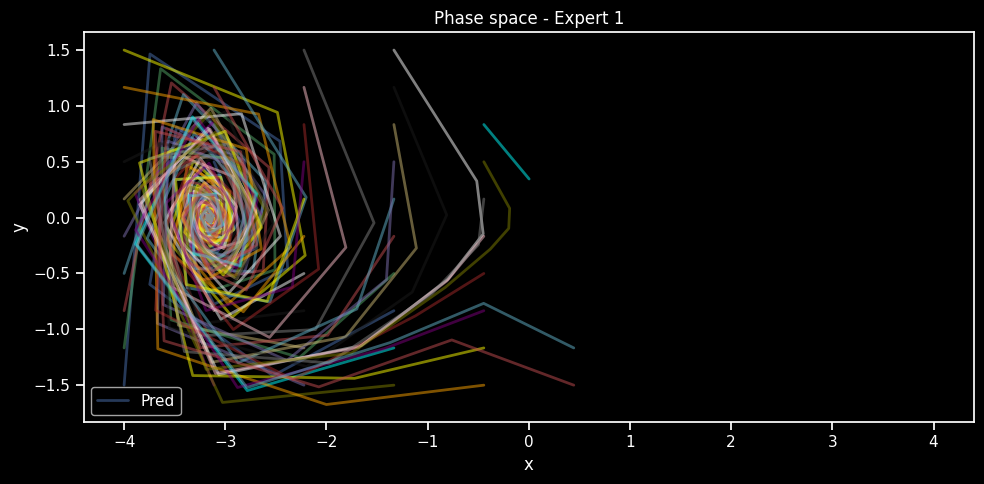

In [ ]:
# %%

## Predict all trajectories using only one expert

def test_expert(model, batch, expert=0):
    X0, t = batch

    # def rhs(x, t):
    #     y = x
    #     layers = model.layers1 if expert==0 else model.layers2
    #     for layer in layers:
    #         y = layer(y)
    #     return y

    def topk_routing(x, k):
        values, indices = jax.lax.top_k(x, k)
        ret = jnp.full_like(x, -jnp.inf)
        ret = ret.at[indices].set(values)
        return ret

    def rhs(x, t):

        ## Top 1 routing function
        # w_out = x
        # for layer in model.layers_rout:
        #     w_out = layer(w_out)
        # gate = jax.nn.softmax(topk_routing(w_out, 1))

        w_out = model.params_router@x.T
        gate = jax.lax.cond(w_out>0, lambda x: jnp.array([1., 0.]), lambda x: jnp.array([0., 1.]), x)

        y1 = x
        y2 = x
        for i in range(len(model.layers1)):
            y1 = model.layers1[i](y1)
            y2 = model.layers2[i](y2)

        # return gate[0]*y1
        # return gate[0]*y1 + gate[1]*y2
        return gate[0]*y1 if expert==0 else gate[1]*y2


    X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None))(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")
    # X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None))(model, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return X_hat


# X = data[0, :, :, :]
res = 10
X = np.array([[x, y] for x in np.linspace(-4, 4, res) for y in np.linspace(-1.5, 1.5, res)])
print(X.shape)

expert_id = 1

# X_hat = test_expert(model, (X[:, 0,:], t), expert=expert_id)
X_hat = test_expert(model, (X[:,:], t), expert=expert_id)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(X.shape[0]):
    if i==0:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', label=f'Pred', title=f'Phase space - Expert {expert_id}', ax=ax, alpha=0.5, color=colors[i])
        # sbplot(X[i, :,0], X[i, :,1], "o", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', ax=ax, alpha=0.5, color=colors[i])
        # sbplot(X[i, :,0], X[i, :,1], "o", lw=1, ax=ax, color=colors[i])

# plt.savefig(f"data/coda_test_env{e}_traj{i}.png", dpi=300, bbox_inches='tight')
# plt.savefig(f"data/test_simple.png", dpi=300, bbox_inches='tight')